In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import itertools
from astropy.io import fits
import scipy
import pickle
import pymaster as nmt
from planck_util import *

In [3]:
freqs = ['100', '143', '217']
splits = ['1', '2']
channels = [ 'TT', 'TE', 'EE' ]
result_dict = {}

ps = PlanckSpectra()

In [ ]:
%%time
for f1,f2 in itertools.product(freqs, repeat=2):
    for s1,s2 in itertools.product(splits, repeat=2):
        if not (( f1, f2, s1, s2 ) in result_dict):
            print( f1, f2, s1, s2 )
            Cb = ps.compute(f1, f2, s1, s2)
            result_dict[( f1, f2, s1, s2 )] = Cb

100 100 1 1


/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


100 100 1 2


In [ ]:
with open('Cb.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

---

In [6]:
with open('Cb.pickle', 'rb') as handle:
    Cb = pickle.load(handle)

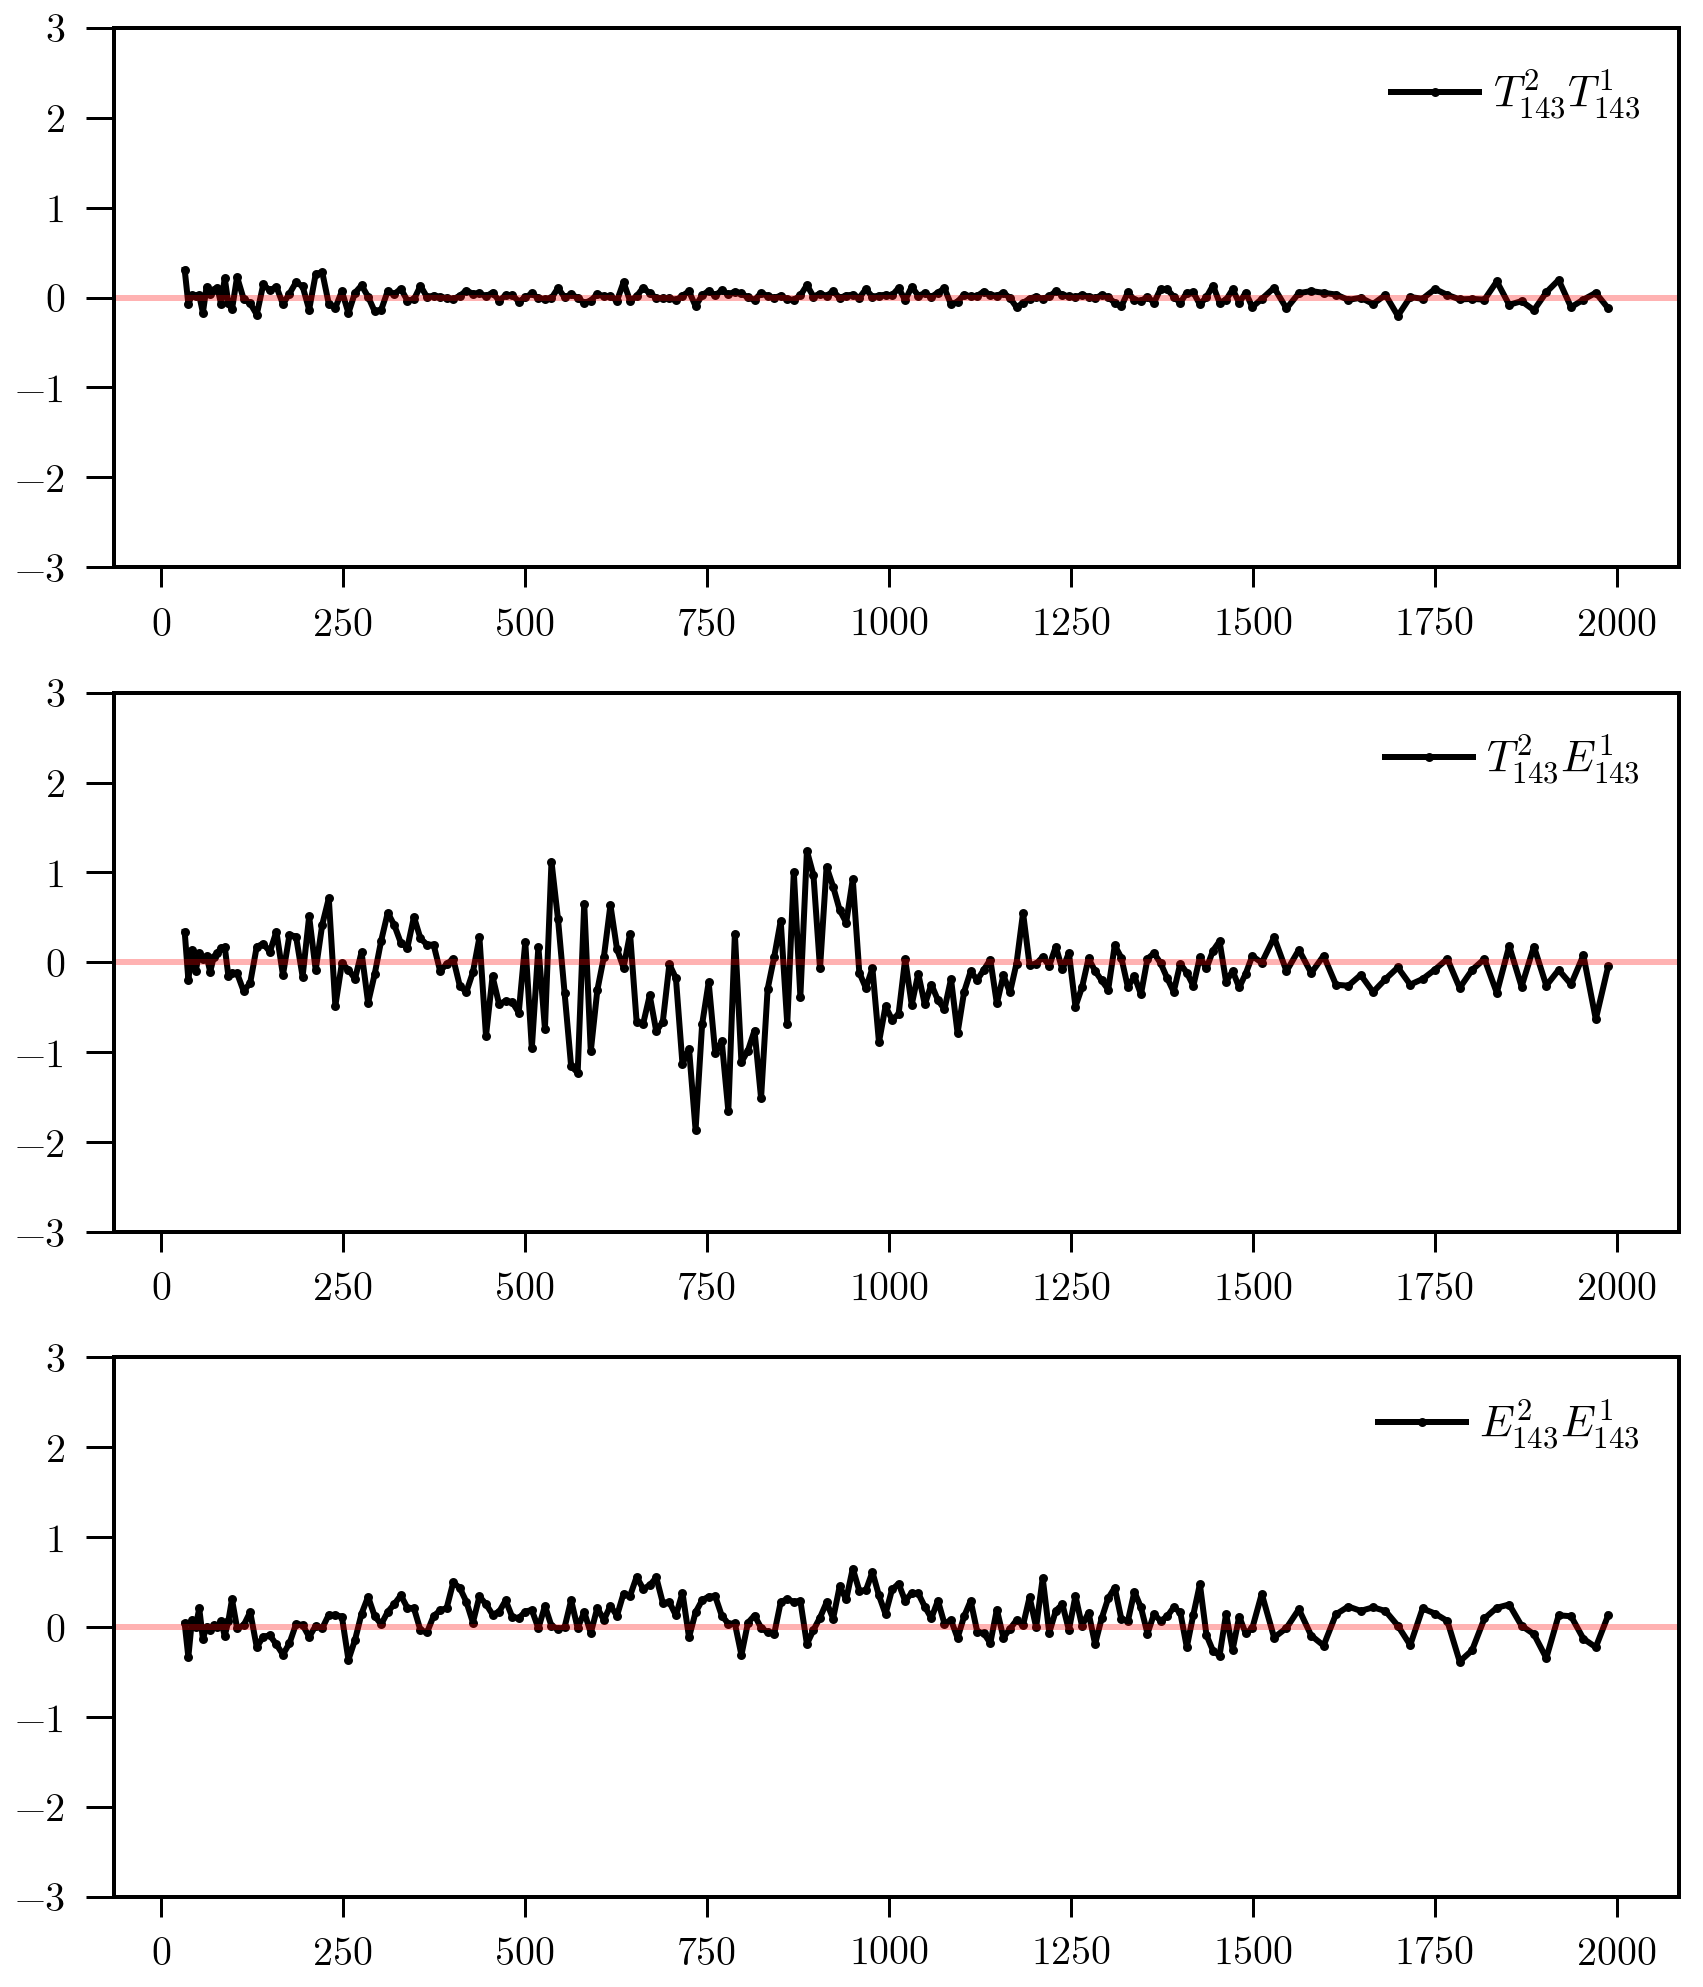

In [14]:

fig, axes = plt.subplots(3,1,figsize=(12,14))

f1, f2, s1, s2 = '143', '143', '2', '1'

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f1}x{f2}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)

    ref_filt = np.in1d(ps.lb, l_ref)
    dl = (Cb[f1, f2, s1, s2][spec] * ps.lb * (ps.lb+1) /2 /np.pi)[ref_filt]
    if spec == 'TE':
        dl +=  (Cb[f1, f2, s2, s1][spec] * ps.lb * (ps.lb+1) /2 /np.pi)[ref_filt]
        dl /= 2
    ax.plot(l_ref, (dl - (cl_ref * dl_ref_fac)) / (error_ref * dl_ref_fac), 
            'k.-', 
            label=( '$' + spec[0] + '_{' + f1 + '}^{' + 
                   s1 + '}' + spec[1] + '_{' + f2 + '}^{' + s2 + '}$'))
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylim(-3,3)
    ax.legend()
    

fig.tight_layout()

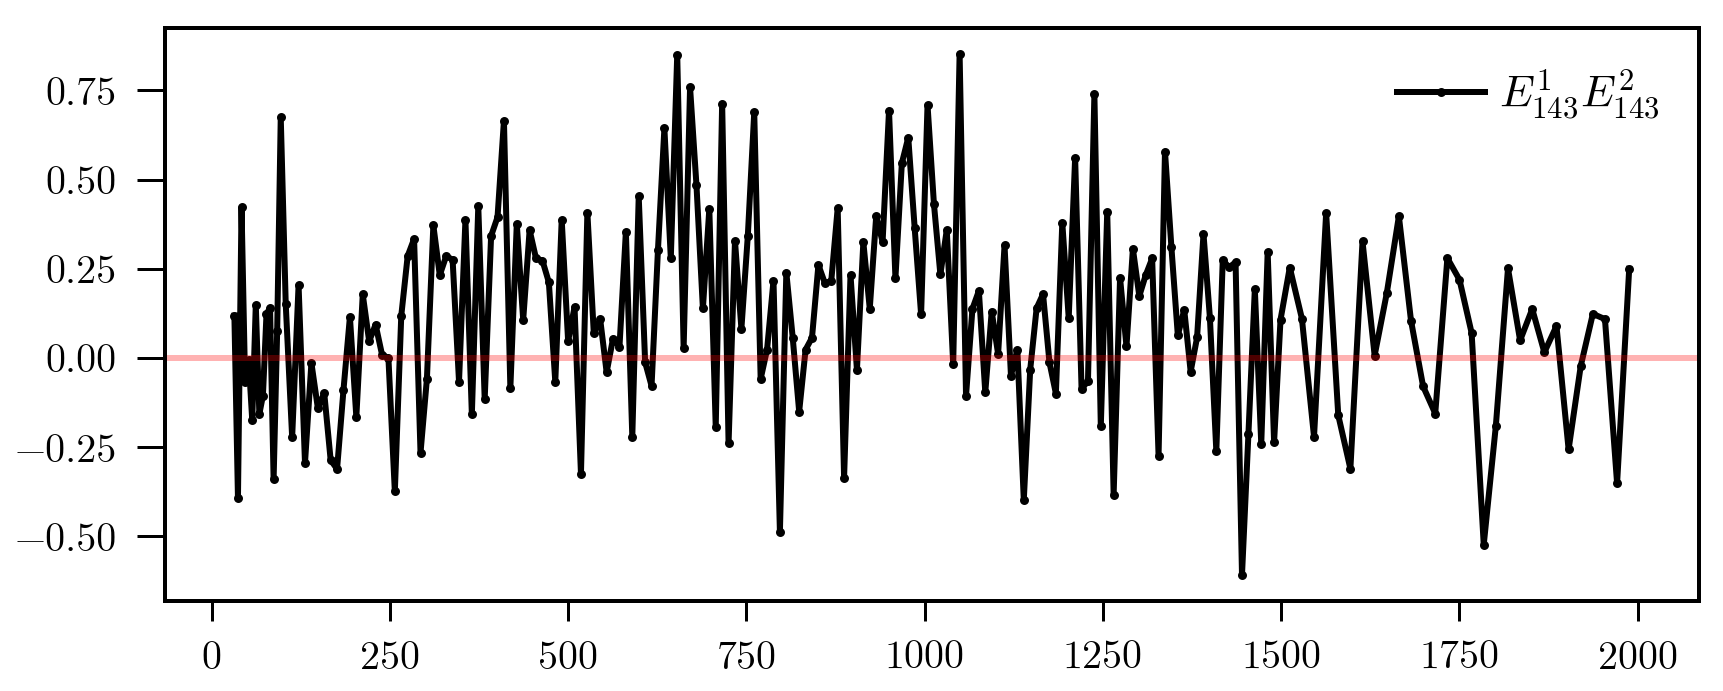

In [52]:

fig, axes = plt.subplots(1,1,figsize=(12,5))

f1, f2, s1, s2 = '143', '143', '1', '2'

for spec, ax in zip(['EE'], [axes]):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f1}x{f2}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)

    dl = np.interp(x=l_ref, xp=ps.lb, fp=Cb[f1, f2, s1, s2][spec] * 1e12) 
    ax.plot(l_ref, (dl - (cl_ref * dl_ref_fac)) / (error_ref * dl_ref_fac), 
            'k.-', 
            label=( '$' + spec[0] + '_{' + f1 + '}^{' + 
                   s1 + '}' + spec[1] + '_{' + f2 + '}^{' + s2 + '}$'))
    ax.axhline(0, color='red', alpha=0.3)
#     ax.set_ylim(-3,3)
    ax.legend()
    

fig.tight_layout()

In [19]:
from astropy.io import ascii

cross_spec_list = ascii.read('cross_spectra.dat', delimiter=',', format='commented_header')

def get_ind(spec):
    if spec == 'TT':
        return 0
    elif spec == 'TE' or spec == 'ET':
        return 1
    else:
        return 2
    
import itertools

splits = ['1', '2']

total_recipe = []
bin_recipe = []
Bbl_recipe = []

for r in cross_spec_list:
    
    ch1, ch2 = r['spec'][0], r['spec'][1]
    f1, f2 = r['f1'], r['f2']
    bin_filt = np.logical_and( ps.lb > r['lmin'], ps.lb < r['lmax'] )
    bin_recipe.append(ps.lb[bin_filt])

    bbls = []
    specs = {}
    for f1, f2 in ( (r['f1'], r['f2']), (r['f2'], r['f1']) ):
        for s1,s2 in itertools.product(splits, repeat=2):
            auto_contains_noise = (f1 == f2 and s1 == s2)
            is_auto = (s1==s2)
            splitkey = (ch1, f1, s1, ch2, f2, s2)
            flipped_splitkey = (ch2, f2, s2, ch1, f1, s1)
            
            if not ((splitkey in specs ) or
                    (flipped_splitkey in specs )
                    or auto_contains_noise or is_auto): # NO AUTOS
                
                spec = Cb[str(f1), str(f2), str(s1), str(s2)][str(ch1)+str(ch2)]
                specs[splitkey] = spec[bin_filt]
#                 bbls.append(Bbl[str(f1), str(f2), str(s1), str(s2)][get_ind(ch1+ch2)][bin_filt,:])
                print( ch1, f1, s1, ch2, f2, s2 )
    
    average_spec = np.mean(np.array([specs[s] for s in specs]), axis=0)
    total_recipe.append( average_spec )
    
#     average_bbl = np.mean(np.array(bbls), axis=0)
#     np.save(f"nmtbbl/bbl_{ch1}{ch2}_{r['f1']}x{r['f2']}", average_bbl)
#     np.savetxt(f"bbltxt/bbl_{ch1}{ch2}_{r['f1']}x{r['f2']}.txt", average_bbl)
#     Bbl_recipe.append( average_bbl )
    print('--')

T 100 1 T 100 2
--
T 143 1 T 143 2
--
T 143 1 T 217 2
T 143 2 T 217 1
--
T 217 1 T 217 2
--
E 100 1 E 100 2
--
E 100 1 E 143 2
E 100 2 E 143 1
--
E 100 1 E 217 2
E 100 2 E 217 1
--
E 143 1 E 143 2
--
E 143 1 E 217 2
E 143 2 E 217 1
--
E 217 1 E 217 2
--
T 100 1 E 100 2
T 100 2 E 100 1
--
T 100 1 E 143 2
T 100 2 E 143 1
T 143 1 E 100 2
T 143 2 E 100 1
--
T 100 1 E 217 2
T 100 2 E 217 1
T 217 1 E 100 2
T 217 2 E 100 1
--
T 143 1 E 143 2
T 143 2 E 143 1
--
T 143 1 E 217 2
T 143 2 E 217 1
T 217 1 E 143 2
T 217 2 E 143 1
--
T 217 1 E 217 2
T 217 2 E 217 1
--


In [26]:
mega_vector = (np.hstack(total_recipe))
np.savetxt('vec_all_spectra_nmt.dat', mega_vector)

In [29]:
col =  plt.rcParams['axes.prop_cycle'].by_key()['color']

planck = np.genfromtxt('planck_spectra/vec_all_spectra.dat')
planck_cl = planck[:,1] #*  planck[:,0] * (planck[:,0]+1) / 2 / np.pi 
planck_cl_err = planck[:,2]# *  planck[:,0] * (planck[:,0]+1) / 2 / np.pi

Text(0, 0.5, '$(C_{\\ell}^{\\mathrm{Planck}} - C_{\\ell}^{nmt}) / \\sigma^{\\mathrm{Planck}}$')

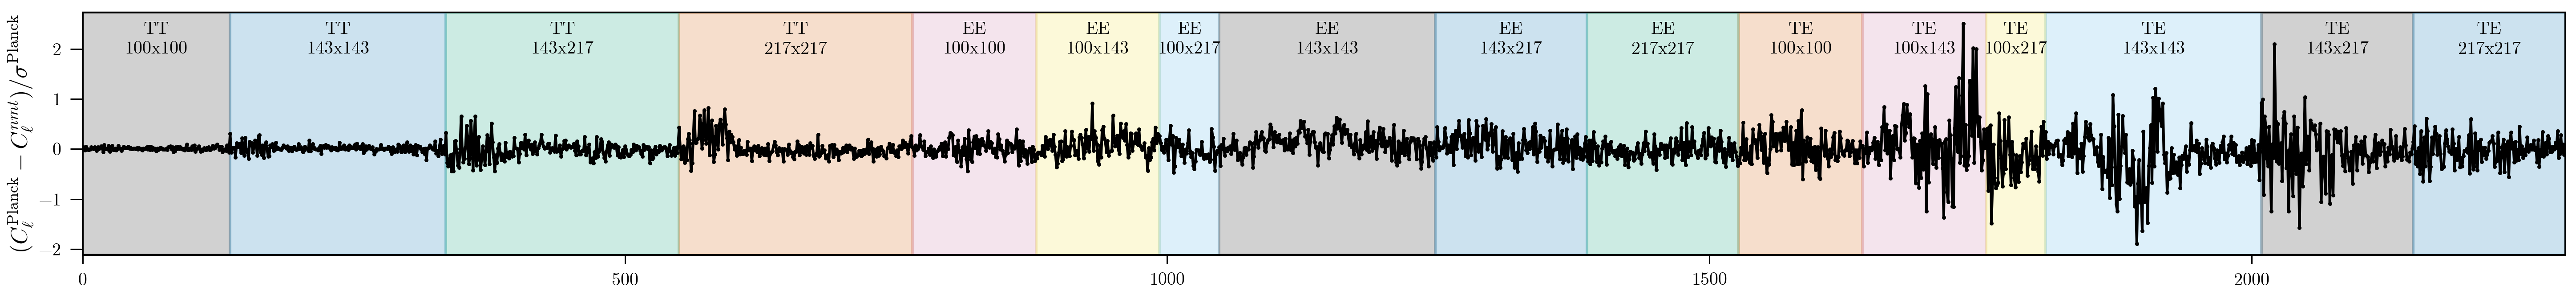

In [34]:
plt.figure(figsize=(50,5))
plt.plot( (mega_vector - planck_cl) / planck_cl_err, 'k.-' )

current_pos = 0
for i, (r, recipe) in enumerate(zip(cross_spec_list, total_recipe)):
    
    ch1, ch2 = r['spec'][0], r['spec'][1]
    f1, f2 = r['f1'], r['f2']
    
    plt.gca().axvspan(current_pos, current_pos + len(recipe), alpha=0.2, color=col[i % len(col)])
    current_pos += len(recipe)
    plt.text(current_pos - len(recipe)/2, 2.3, f'{ch1}{ch2}', horizontalalignment='center', fontsize=20)
    plt.text(current_pos - len(recipe)/2, 1.9, f'{f1}x{f2}', horizontalalignment='center', fontsize=20)
    
plt.xlim(0, 2289)
plt.ylabel('$(C_{\ell}^{\mathrm{Planck}} - C_{\ell}^{nmt}) / \sigma^{\mathrm{Planck}}$')